# RX Sensitivity Training

TODO:
1. Find meta model to handle missing input values
    - Add filter to remove all null rows in train or test data in default train fn
2. Add matrix completion or MICE as imputation for Y_train
3. Add RPPA predictions to meta model inputs
4. Convert this to a script so that multiprocessing can be used?
5. Set up storage of predictions for different experiments so that progress can be documented well
6. Convert mutations back to amino acid change representation
7. Try TPOT as base learner

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data
from py_utils import collection_utils

In [6]:
# entity_mappings={
#     entity.CELL_LINE: api.get_entity_mapping(entity.CELL_LINE),
#     entity.PRIMARY_SITE: api.get_entity_mapping(entity.PRIMARY_SITE)
# }
# df = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, mappings=entity_mappings)
# df['INDICATOR'] = 1

In [5]:
# df.head()

In [4]:
# df[df['CELL_LINE_ID:MGDS'].isnull()]

In [3]:
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'VALUE']).size().value_counts()
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'INDICATOR']).size().value_counts()

In [2]:
# df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC']).size().value_counts()

In [22]:
datasets = api.get_genomic_data_availability()
datasets = [v for v in datasets if v[1] == dtyp.DRUG_SENSITIVITY]
datasets

[('gdsc_v2', 'drug-sensitivity'),
 ('ccle_v1', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [3]:
datasets = api.get_genomic_data_availability()
d = db.cache_prep_operation(lambda: feature_data.get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-01-24 13:06:25,636:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


In [4]:
d.head()

ccle_v1                   \
                                         gene-copy-number                    
                                                     A1BG A1BG-AS1    A1CF   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM          -0.1544  -0.1544 -0.0985   
143B              BONE                            -0.2120  -0.2120  0.1580   
184A1             BREAST                              NaN      NaN     NaN   
184B5             BREAST                              NaN      NaN     NaN   
2004              NULL                                NaN      NaN     NaN   

                                                                          \
                                                                           
                                             A2M   A2ML1  A4GALT   A4GNT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM -0.1819 -0.1819 -0.1732  0.2575   
143B              BONE                   -0.1753 -0.1753 -0.2536  0.2060   
184A1             BREAST                     NaN     NaN     NaN     NaN   
184B5             BREAST                     NaN     NaN     NaN     NaN   
2004              NULL                       NaN     NaN     NaN     NaN   

                                                                    ...     \
                                                                    ...      
                                            AAAS    AACS  AACSP1    ...      
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                 ...      
1321N1            CENTRAL_NERVOUS_SYSTEM -0.0404 -0.1284  0.1682    ...      
143B              BONE                   -0.1445 -0.2757  0.2150    ...      
184A1             BREAST                     NaN     NaN     NaN    ...      
184B5             BREAST                     NaN     NaN     NaN    ...      
2004              NULL                       NaN     NaN     NaN    ...      

                                              ncidream_v1                    \
                                         drug-sensitivity                     
                                                    MG132 MG132B NELFINAVIR   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
1321N1            CENTRAL_NERVOUS_SYSTEM              NaN    NaN        NaN   
143B              BONE                                NaN    NaN        NaN   
184A1             BREAST                         2.044571    NaN   1.700421   
184B5             BREAST                         2.052219    NaN   1.673305   
2004              NULL                                NaN    NaN        NaN   

                                                                            \
                                                                             
                                         NILONTINIB OLOMOUCINEII    PS1145   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM        NaN          NaN       NaN   
143B              BONE                          NaN          NaN       NaN   
184A1             BREAST                   1.308054     1.704059  1.001932   
184B5             BREAST                   1.308054     1.709954  1.001932   
2004              NULL                          NaN          NaN       NaN   

                                                                          \
                                                                           
                                               QNZ  TCSPIM11 TRASTUZUMAB   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM       NaN       NaN         NaN   
143B              BONE                         NaN       NaN         NaN   
184A1             BREAST                  1.499077  1.640310    1.718021   
184B5       

In [6]:
def summarise_cols(name, cols):
    cts = pd.Series([':'.join(c[:2]) for c in cols]).value_counts()
    print('{}| Num levels = {}, Count by: {}'.format(name, cols.nlevels, cts))
summarise_cols('', d.columns)

| Num levels = 3, Count by: ncidream_v1:gene-rna-seq        30154
ncidream_v1:gene-copy-number    27230
nci60_v2:gene-copy-number       23367
nci60_v2:gene-expression        22370
ccle_v1:gene-copy-number        20381
gdsc_v2:gene-exome-seq          19100
ncidream_v1:gene-expression     18632
gdsc_v2:gene-expression         17419
ccle_v1:gene-expression         16042
ncidream_v1:gene-methylation    14475
ncidream_v1:gene-exome-seq      11995
nci60_v2:gene-exome-seq         11203
nci60_v2:drug-sensitivity        4210
ccle_v1:gene-exome-seq           2165
ctd_v2:drug-sensitivity           545
gdsc_v2:drug-sensitivity          251
ncidream_v1:drug-sensitivity       28
dtype: int64


In [7]:
sites = d.index.get_level_values('PRIMARY_SITE:MGDS')
sites.value_counts()

HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    244
LUNG                                  230
SKIN                                   88
BREAST                                 86
CENTRAL_NERVOUS_SYSTEM                 77
LARGE_INTESTINE                        68
OVARY                                  66
BONE                                   61
UPPER_AERODIGESTIVE_TRACT              60
NULL                                   54
KIDNEY                                 53
PANCREAS                               49
STOMACH                                48
AUTONOMIC_GANGLIA                      39
OESOPHAGUS                             37
URINARY_TRACT                          30
ENDOMETRIUM                            29
LIVER                                  29
SOFT_TISSUE                            28
PLEURA                                 26
THYROID                                18
CERVIX                                 14
BILIARY_TRACT                          12
PROSTATE                          

In [7]:
cols = [v for v in api.get_genomic_data_availability() if v[1] == dtyp.DRUG_SENSITIVITY]
#d[cols].head()
#d[cols[:2]].head()
cols

[('gdsc_v2', 'drug-sensitivity'),
 ('ctd_v2', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [14]:
drugs = pd.Series([c[2] for c in d if c[1] == dtyp.DRUG_SENSITIVITY])
drugs.drop_duplicates().head()

0            17AAG
1    5FLUOROURACIL
2    5Z7OXOZEAENOL
3           681640
4          A443654
dtype: object

In [15]:
#test_drugs = ['NAVITOCLAX', 'NUTLIN3A']
test_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']
[v for v in drugs if v in test_drugs]

['AG014699',
 'NAVITOCLAX',
 'NUTLIN3A',
 'PD0332991',
 'PLX4720',
 'SB590885',
 'NAVITOCLAX',
 'PLX4720']

In [7]:
#response_fields = [c for c in d if c[1] == dtyp.DRUG_SENSITIVITY]

from ml.sklearn import feature_selection as ml_feature_selection
from ml.sklearn.baseline import AverageRegressor
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskLasso, RidgeCV, LassoCV, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from py_utils import collection_utils

import pdb

def get_drug_sensitivity_selector(source):
    def selector(d):
        return [c for c in d if c[0] == source and c[1] == dtyp.DRUG_SENSITIVITY]
    return selector

def get_feature_selector(source, data_type, names=None):
    def selector(d):
        # summarize_cols('features', d.columns)
        feats = [c for c in d if c[0] == source and c[1] == data_type]
        if names is None:
            return feats
        cols = [c for c in feats if c[2] in names]
        assert len(cols) > 0, 'Feature selector resulted in empty set'
        return cols
    return selector


def remove_null_rows(X, Y=None):
    non_na_mask = X.notnull().any(axis=1)
    if non_na_mask.any():
        n_after = np.sum(non_na_mask)
        assert n_after > 0
        n_before = len(X)
        n_diff = n_before - n_after
        X = X[non_na_mask.values]
        if Y is not None:
            Y = Y[non_na_mask.values]
            assert len(X) == len(Y) == n_after
        else:
            assert len(X) == n_after
    return X, Y

    
def get_default_train_fn(est_factory, imputer_factory=None):
    def train(X_train, Y_train, X_test, prefit_est):
        
        # Remove rows from training data where response or features are always null
        Y_train, X_train = remove_null_rows(Y_train, X_train)
        X_train, Y_train = remove_null_rows(X_train, Y_train)
        
        # TODO: eliminate rows from X_test and Y_test if any are all null
        # TODO: make Y_train imputation better
        
        if imputer_factory is not None:
            
            # Print percent completion of training responses:
            # * It was found that results here for 6 main target drugs were between 2 and 12% incomplete
            # is_na = Y_train.isnull().sum().sum()
            # pct_na = 100 * is_na / (Y_train.shape[0] * Y_train.shape[1])
            # print('Y_train shapes: ', Y_train.shape, Y_train.dropna().shape, pct_na)
            
            y = imputer_factory().fit_transform(Y_train)
            Y_train = pd.DataFrame(y, index=Y_train.index, columns=Y_train.columns)
            
        if prefit_est is not None:
            est = prefit_est
        else:
            est = est_factory()
            est.fit(X_train, Y_train)
            
        Y_pred = None
        if X_test is not None: 
            # print('X_test all null row counts: ', X_test.isnull().all(axis=1).value_counts())
            X_test, _ = remove_null_rows(X_test)
            Y_pred = pd.DataFrame(est.predict(X_test), index=X_test.index, columns=Y_train.columns)
        return est, Y_pred
    return train


# Test mode
# target_drugs = ['NAVITOCLAX', 'NUTLIN3A']
# target_genes = [
#     'A1BG', 'A1GB-AS1', 'A1CF', 'A2M', 'A2ML1',
#     'YAP1', 'WNK3', 'WHSC1L1', 'TNFRSF13B', 'PRKCB', 'PAX2', 'MNX1'
# ]

# Real targets
target_genes = None
target_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']


# target_drugs = ['Navitoclax', 'Nutlin', 'AG-014699', 'PD-0332991', 'PLX4720', 'SB590885']

# rf_factory = lambda: Pipeline([
#     ('impute', Imputer()), 
#     ('est', RandomForestRegressor())
# ])
# knn_factory = lambda: Pipeline([
#     ('impute', Imputer()), 
#     ('scale', RobustScaler()), 
#     ('est', KNeighborsRegressor())
# ])
 
def_imputer_factory = lambda: Imputer()
zero_imputer_factory = lambda: FunctionTransformer(func=lambda X: np.nan_to_num(X), validate=False)


def regressor_factory(estimator_factory, discrete=False, k=500, scale=True, 
                      select=True, imputer_factory=def_imputer_factory):
    def create_pipeline():
        steps = []
        steps += [('impute', imputer_factory())]
        steps += [('nzv', VarianceThreshold())]
        if scale:
            steps += [('scale', RobustScaler())]
        if select:
            # TODO: Modify this to also support discrete features; f_regression is ok for continuous
            # and ordered categorical/binary but less so for unordered categorical (so maybe that's ok?)
            base_selector = ml_feature_selection.SelectAtMostKBest(f_regression, k=k, validate=False)
            selector = ml_feature_selection.MultiOutputSelect(base_selector=base_selector, strategy='any')
            steps += [('select', selector)]
        steps += [('est', estimator_factory())]
        return Pipeline(steps)
    return create_pipeline


def mtlasso_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiTaskLasso(), **kwargs)

def mtlassocv_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiTaskLassoCV(), **kwargs)

# def lasso_regressor_factory(alphas=[.1, .5, 1., 2., 5.], **kwargs):
#     return regressor_factory(lambda: MultiOutputRegressor(LassoCV(alphas=alphas)), **kwargs)
def lasso_regressor_factory(n_alphas=5, **kwargs):
    #return regressor_factory(lambda: MultiOutputRegressor(LassoCV(n_alphas=n_alphas)), **kwargs)
    return regressor_factory(lambda: MultiOutputRegressor(Lasso()), **kwargs)

def ridgecv_regressor_factory(**kwargs):
    #return regressor_factory(lambda: MultiOutputRegressor(LassoCV(n_alphas=n_alphas)), **kwargs)
    return regressor_factory(lambda: MultiOutputRegressor(RidgeCV()), **kwargs)

def mtknn_regressor_factory(**kwargs):
    return regressor_factory(lambda: KNeighborsRegressor(), **kwargs)

def mtrf_regressor_factory(**kwargs):
    return regressor_factory(lambda: RandomForestRegressor(), **kwargs)

def rf_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiOutputRegressor(RandomForestRegressor()), **kwargs)

def etr_regressor_factory(**kwargs):
    return regressor_factory(lambda: ExtraTreesRegressor(), **kwargs)

def pos_lasso_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiOutputRegressor(LassoCV(positive=True)), **kwargs)

def avg_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiOutputRegressor(AverageRegressor()), **kwargs)
 

pan_site_estimators = {
    'response_selector': get_feature_selector(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        
        # CCLE Gene Expression
        'pans_rf_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(scale=False), def_imputer_factory)
        },
        'pans_mtrf_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(mtrf_regressor_factory(scale=False), def_imputer_factory)
        },
#         'pans_knn_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(knn_regressor_factory(), def_imputer_factory)
#         },
        'pans_etr_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(etr_regressor_factory(scale=False), def_imputer_factory)
        },
        'pans_lin_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # GDSC Gene Expression
        'pans_rf_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pans_mtrf_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(mtrf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
#         'pans_knn_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(knn_regressor_factory(), def_imputer_factory)
#         },
        'pans_etr_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(etr_regressor_factory(scale=False), def_imputer_factory)
        },
        'pans_lin_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        }
        
    }
}

per_site_estimators = {
    'response_selector': get_feature_selector(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        # CCLE Gene Expression
        'pers_etr_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(etr_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pers_lin_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # CCLE Mutations
        'pers_lin_ccle_mu': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(
                lasso_regressor_factory(discrete=True, scale=False, imputer_factory=zero_imputer_factory), 
                def_imputer_factory
            )
        },
        
        # GDSC Gene Expression
        'pers_etr_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(etr_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pers_lin_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # GDSC Mutations
        'pers_lin_gdsc_mu': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(
                lasso_regressor_factory(discrete=True, scale=False, imputer_factory=zero_imputer_factory), 
                def_imputer_factory
            )
        }
    }
}


meta_response_selector = lambda d: [c for c in d if c[3] == 'Actual']
meta_feature_selector = lambda d: [c for c in d if not c[3] in ['Actual'] and not c[3].startswith('meta')]
meta_estimators = {
    'response_selector': meta_response_selector,
    'estimators': {
        'meta_rf': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(rf_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_poslasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(pos_lasso_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_mtlasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(mtlassocv_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_lasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(lasso_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_ridgecv': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(ridgecv_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_avg': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(avg_regressor_factory(select=False, scale=False), def_imputer_factory)
        }
        
    }
}


In [16]:
#zero_imputer_factory().fit_transform(d[(src.CCLE_v1, dtyp.GENE_EXOME_SEQ)]).shape

In [19]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [8]:
%pdb on
site = 'BREAST'
cv_sites = [site]
cv = rx_train.get_cv_folds(d, sites=cv_sites)
res = rx_train.run_training(d, cv, pan_site_estimators, per_site_estimators, meta_estimators)
%pdb off

Automatic pdb calling has been turned ON


2017-01-24 12:28:10,333:INFO:mgds.data_modeling.training01: Beginning training for site "BREAST" [d_train.shape = (1387, 239567), d_test.shape = (86, 239567)]
2017-01-24 12:28:10,334:INFO:mgds.data_modeling.training01: Training pan site refit models ...
2017-01-24 12:28:47,654:INFO:mgds.data_modeling.training01: Training for pan site refit models complete
2017-01-24 12:28:47,655:INFO:mgds.data_modeling.training01: Training per site refit models ...
2017-01-24 12:28:49,045:INFO:mgds.data_modeling.training01: Training for per site refit models complete
2017-01-24 12:28:49,046:INFO:mgds.data_modeling.training01: Running inner cross validation for meta estimator data generation ...
2017-01-24 12:28:49,242:DEBUG:mgds.data_modeling.training01: [fold 1 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (68, 239567), d_test.shape = (18, 239567)]
2017-01-24 12:28:51,972:DEBUG:mgds.data_modeling.training01: [fold 1 of 5] Collecting prediction

Automatic pdb calling has been turned OFF


## Save Results

In [9]:
version = 'v5'
notes = """
- 100 selected features
- Breast only
- Add removal of null rows in training features, responses, and test features (previously only training responses)
- Mean imputation on responses in training
- Mean imputation on inputs to meta estimator
- No RPPA
"""

description = rx_train.get_result_description(notes)
rx_train.save_training_results({'cv': cv, 'res': res}, 'multi_source', version, description)

2017-01-24 12:32:25,187:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/archive/v5/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/archive/v5'

## Quick Analysis

Any real, in-depth analysis should be in a separate notebook

In [13]:
est = res[site]['models']['meta']['meta_rf']

KeyError: 'meta_mtrf'

In [87]:
res[site]['models']['pan_site']['pans_lin_ccle_ge'].named_steps#['select'].support_matrix_.shape

{'est': MultiOutputRegressor(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
     max_iter=1000, n_alphas=5, n_jobs=1, normalize=False, positive=False,
     precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
     verbose=False),
            n_jobs=1),
 'impute': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'nzv': VarianceThreshold(threshold=0.0),
 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'select': MultiOutputSelect(base_selector=None, strategy='any')}

In [88]:
dt = res[site]['models']['per_site']
for m in dt:
    if '_lin_' not in m:
        continue
    print(dt[m].named_steps['est'].estimators_[0].alpha_)

0.13337972526
0.152887795677
0.074074867177
3.74933897033


In [32]:
#pd.Series(est.named_steps['est'].coef_[2], index=est.input_fields).sort_values()

In [12]:
pd.Series(est.named_steps['est'].feature_importances_, index=est.input_fields).sort_values()

AttributeError: 'MultiOutputRegressor' object has no attribute 'feature_importances_'

In [90]:
dt = res[site]['prediction_data']
dt.head()

gdsc_v2                   \
                                            drug-sensitivity                    
                                                    AG014699       NAVITOCLAX   
                                            pers_etr_ccle_ge pers_etr_ccle_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               3.639850         1.454829   
BT483             BREAST            1               4.136980         2.038647   
CAL51             BREAST            1               3.853103         0.695404   
HCC1143           BREAST            1               3.682613         1.549059   
HCC1395           BREAST            1               4.441772         1.456598   

                                                                               \
                                                                                
                                                    NUTLIN3A        PD0332991   
                                            pers_etr_ccle_ge pers_etr_ccle_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               3.892228         2.662130   
BT483             BREAST            1               5.027648         3.852413   
CAL51             BREAST            1               4.252157         3.406625   
HCC1143           BREAST            1               3.709666         2.985288   
HCC1395           BREAST            1               4.507492         3.272766   

                                                                               \
                                                                                
                                                     PLX4720         SB590885   
                                            pers_etr_ccle_ge pers_etr_ccle_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               4.517447         4.012041   
BT483             BREAST            1               5.161765         3.945619   
CAL51             BREAST            1               4.184006         3.619178   
HCC1143           BREAST            1               4.275209         3.447271   
HCC1395           BREAST            1               4.752753         3.772334   

                                                                               \
                                                                                
                                                    AG014699       NAVITOCLAX   
                                            pers_lin_ccle_mu pers_lin_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               3.937358         1.494733   
BT483             BREAST            1               3.816607         1.494733   
CAL51             BREAST            1               3.688236         1.494733   
HCC1143           BREAST            1               4.037864         1.494733   
HCC1395           BREAST            1               4.143612         1.494733   

                                                                               \
                                                                                
                                                    NUTLIN3A        PD0332991   
                                            pers_lin_ccle_mu pers_lin_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               4.212633         3.143303   
BT483             BREAST            1               4.212633         3.143303   
CAL51             BREAST            1               4.212633         3.143303   
HCC1143           BREAST            1               4.212633         3.143303   
HCC1395           BREAST            1               4.212633         3.143303   

In [91]:
dt.index.get_level_values('FOLD_ID').value_counts()

1    18
5    17
4    17
3    17
2    17
Name: FOLD_ID, dtype: int64

In [40]:
# dt[[
#     ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_rf_ccle_cn'),
#     ('gdsc_v2', 'drug-sensitivity', 'NUTLIN3A', 'pers_rf_ccle_cn'),
# ]].head()

In [14]:
from sklearn.metrics import r2_score, mean_squared_error
        
def plot_scores(d_score, figsize=2, figaspect=5, legend_margin=(1.13, 1)):
    # Create a boxplot per task (in rows) with model names on the x axis and colors denoting metrics
    g = sns.FacetGrid(
        d_score, row='DRUG_NAME', size=figsize, aspect=figaspect, 
        legend_out=False, sharey=False
    )

    # Map grid to boxplot function
    def plot_data(*args, **kwargs):
        sns.boxplot(data=kwargs['data'], x='MODEL_NAME', y='VALUE', hue='METRIC')
    g.map_dataframe(plot_data)
    [ax.legend(bbox_to_anchor=legend_margin) for ax in g.axes.ravel()]

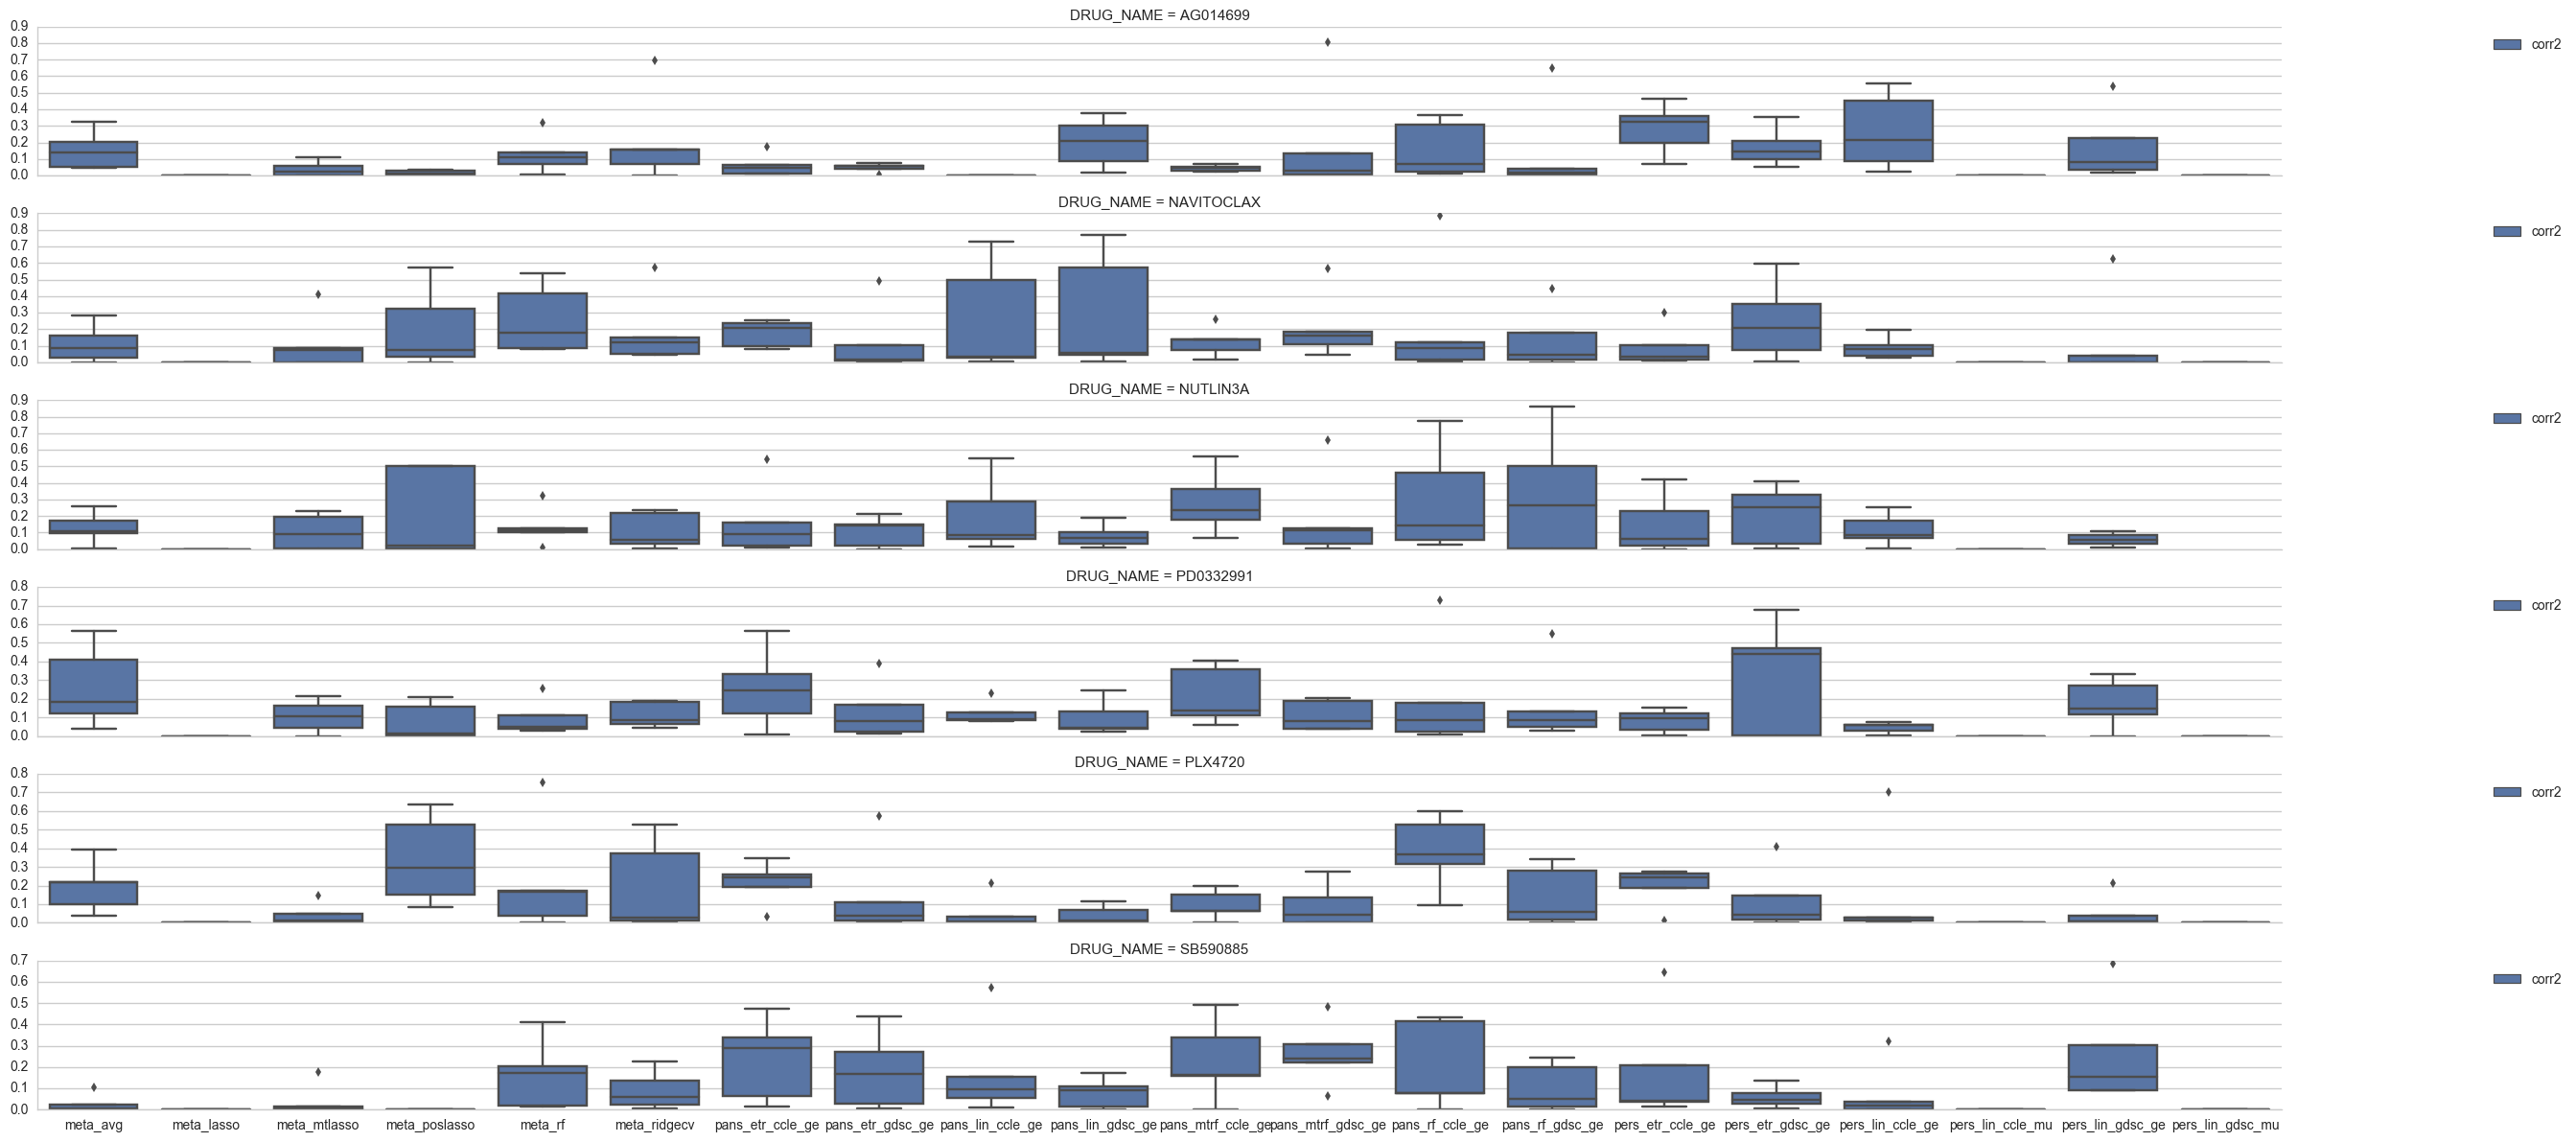

In [15]:
d_pred = res[site]['prediction_data']
score_functions = {
    #'r2': r2_score,
    'corr2': lambda y_true, y_pred: y_pred.corr(y_true)**2,
    #'mse': mean_squared_error
}
d_score = rx_train.get_scores(d_pred, score_functions)
plot_scores(d_score, figaspect=12)

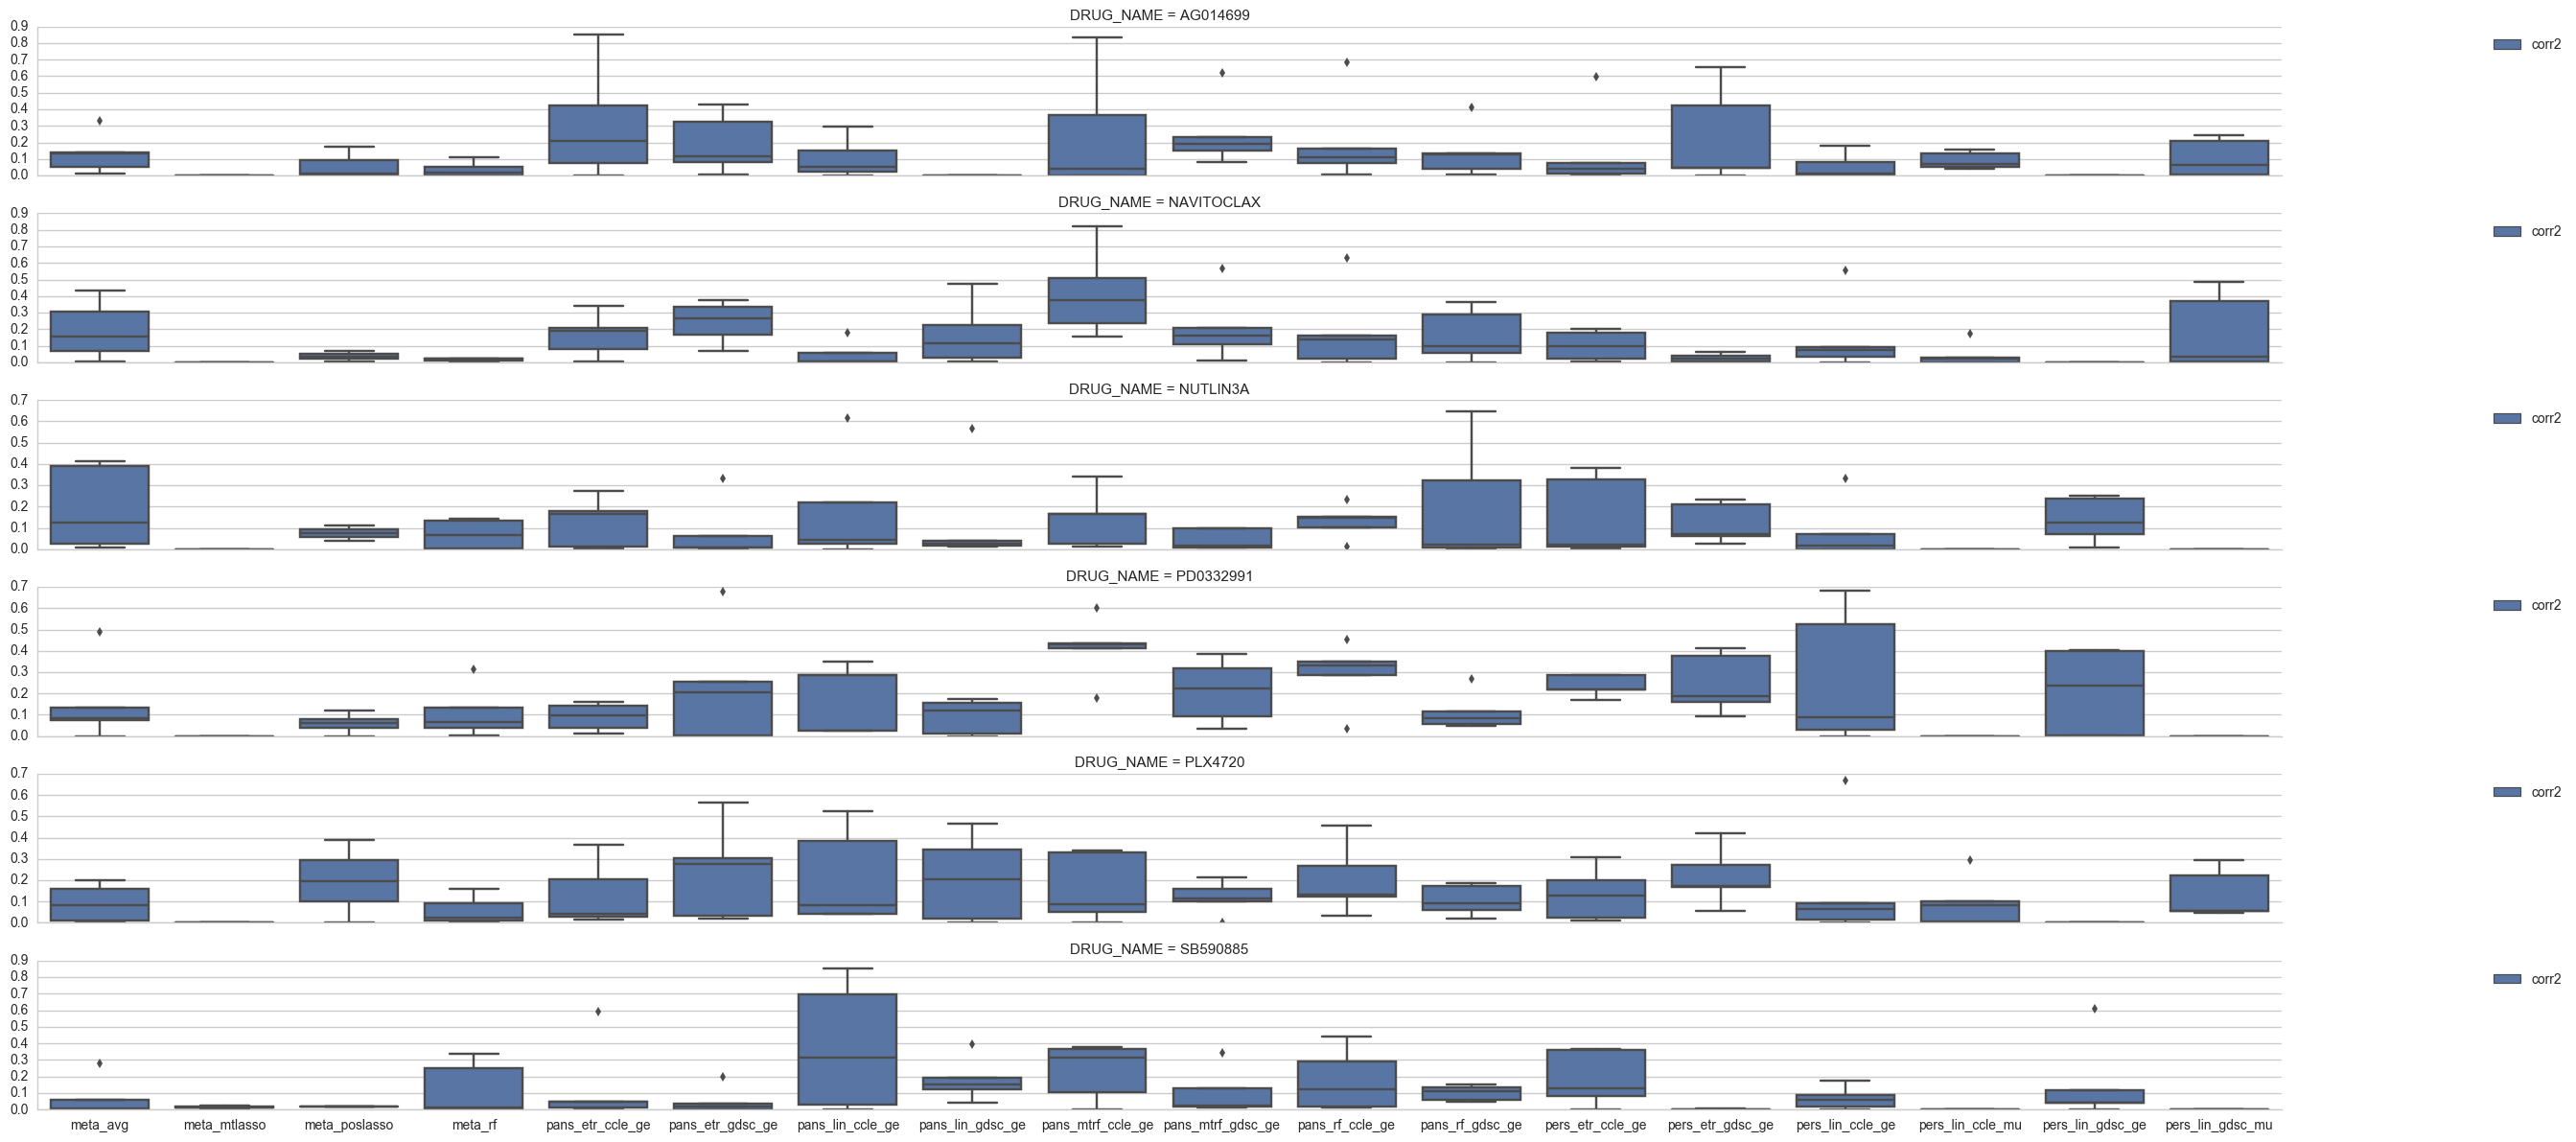

In [102]:
d_pred = res[site]['prediction_data']
score_functions = {
    #'r2': r2_score,
    'corr2': lambda y_true, y_pred: y_pred.corr(y_true)**2,
    #'mse': mean_squared_error
}
d_score = rx_train.get_scores(d_pred, score_functions)
plot_scores(d_score, figaspect=12)

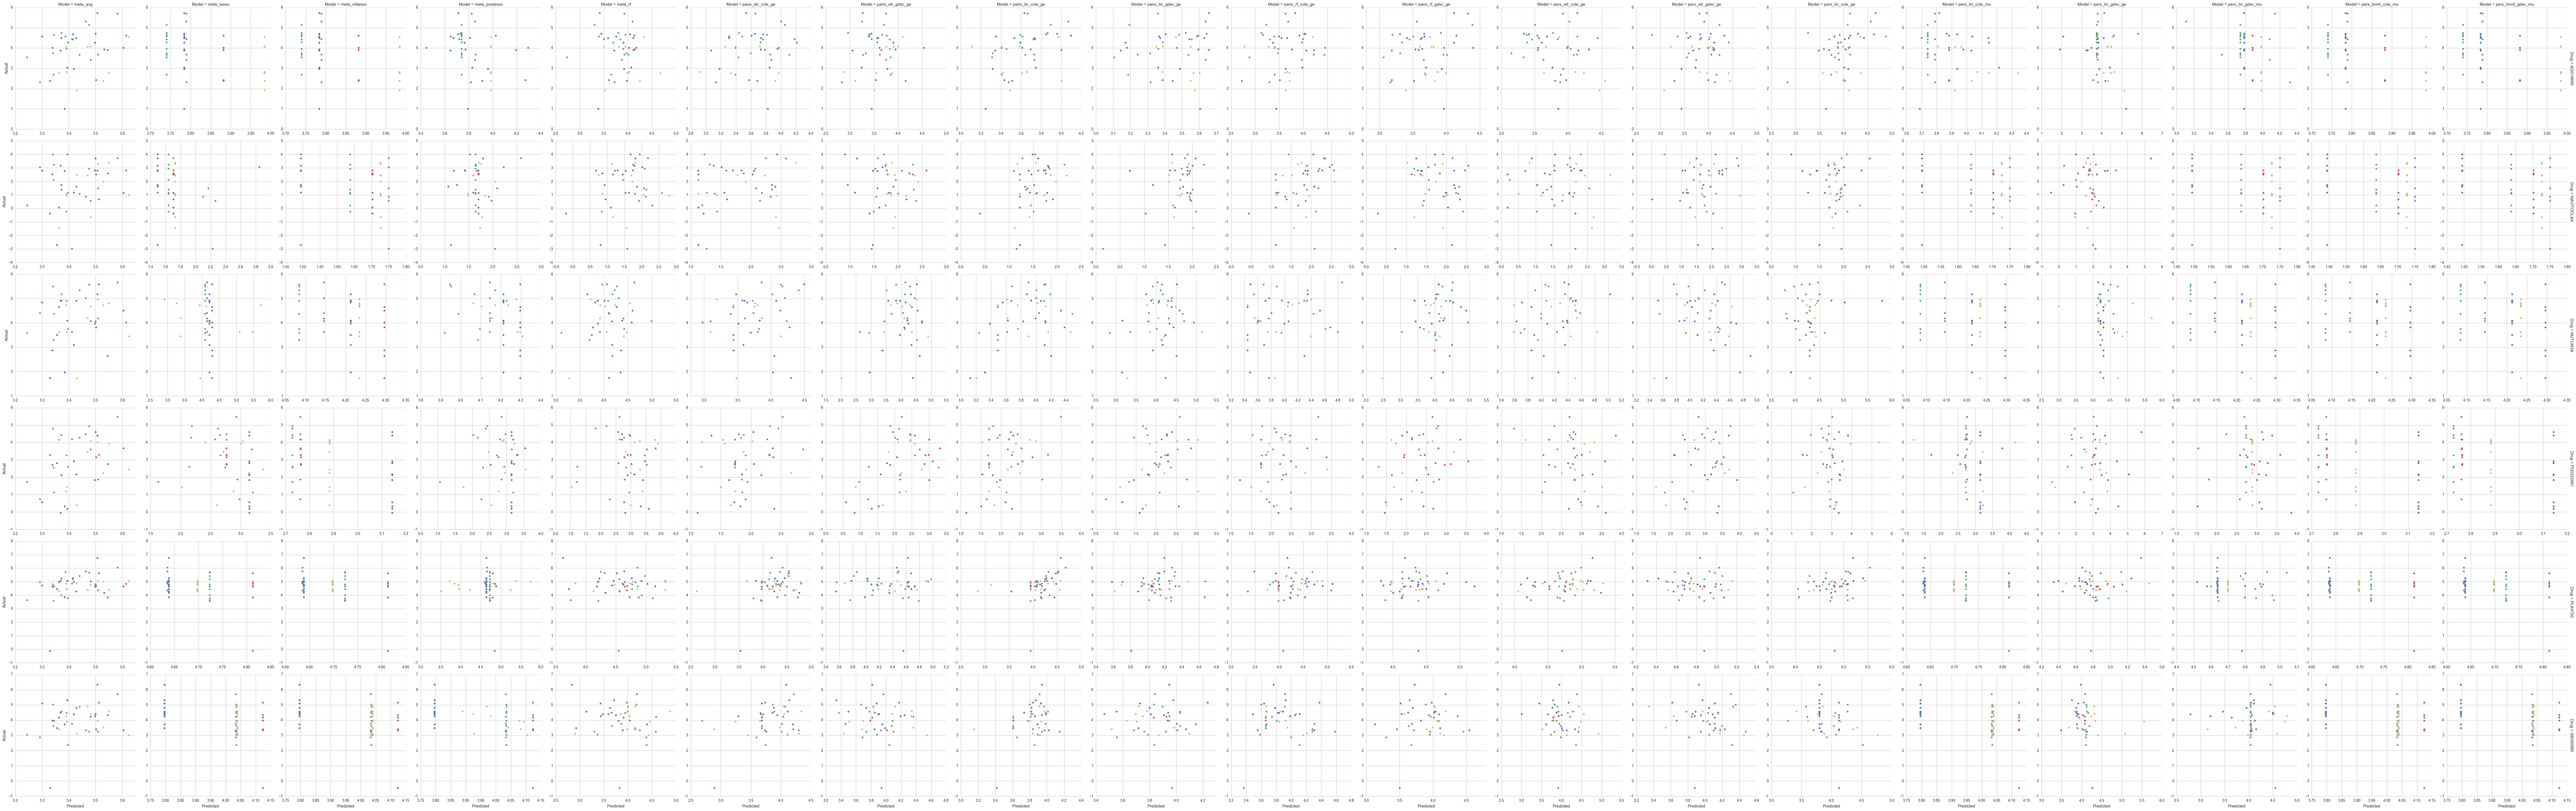

In [95]:

def plot_predictions(d_pred, share_axes=False):
    c_actual = [c for c in d_pred if c[-1] == 'Actual']
    c_pred = d_pred.columns.difference(c_actual)
    
    d = []
    for c_act in c_actual:
        drug_name = c_act[-2]
        c_drug_pred = [c for c in c_pred if c[-2] == drug_name]
        for c_pre in c_drug_pred:
            model_name = c_pre[-1]
            d.append(pd.DataFrame({
                'Predicted': d_pred[c_pre],
                'Actual': d_pred[c_act],
                'Drug': drug_name,
                'Model': model_name,
                'Fold': d_pred.index.get_level_values('FOLD_ID')
            }))
        
    d = pd.concat(d)
    g = sns.FacetGrid(
            d, row='Drug', col='Model', hue='Fold', margin_titles=True, size=5, aspect=1,
            sharex=share_axes, sharey=share_axes)
    #g.map(sns.regplot, 'Predicted', 'Actual')
    g.map(plt.scatter, 'Predicted', 'Actual')
    return g, d

grid, d_plt = plot_predictions(d_pred)

In [ ]:
sns.regplot

In [68]:
xx = np.arange(1, 10)
yx = xx * 1 + np.random.rand(len(xx))
r2_score(xx, yx)

0.97001348752971261